In [1]:
import pandas as pd
import os

Define Paths

In [2]:
TRANSFORMED_DATA_DIR = "../../data/silver"
MART_DATA_DIR = "../../data/gold"
os.makedirs(MART_DATA_DIR, exist_ok=True)

Load Transformed Data

In [ ]:
# Load transformed data
tables = [
    "User", "Designation", "Course", "EmployeeProgress", 
    "Skill", "UserSkill", "DesignationSkill", "CourseSkill"
]

# Dictionary to hold DataFrames for each table
transformed_dfs = {}

for table in tables:
    file_path = os.path.join(TRANSFORMED_DATA_DIR, f'prep_{table}.csv')
    transformed_dfs[table] = pd.read_csv(file_path)
    print(transformed_dfs[table].columns)
transformed_dfs["User"].head()

Create User Dimension Table

In [ ]:
# Create User Dimension Table
user_dim = transformed_dfs["User"][['id', 'username', 'createdAt']]
user_dim.columns = ['user_id', 'user_name', 'joined_at']  # Rename columns
print("User Dimension Preview:")
print(user_dim.head())


Create Designation Dimension Table

In [ ]:
# Create Designation Dimension Table
designation_dim = transformed_dfs["Designation"][['id', 'name']]
designation_dim.columns = ['designation_id', 'designation_name']  # Rename columns
print("\nDesignation Dimension Preview:")
print(designation_dim.head())


Create Course Dimension Table

In [ ]:
# Create Course Dimension Table
course_dim = transformed_dfs["Course"][['course_id', 'title', 'difficulty', 'language', 'totalTime', 'totalModules', 'created_at']]
print("\nCourse Dimension Preview:")
print(course_dim.head())


Create Skill Dimension Table

In [ ]:
# Create Skill Dimension Table
skill_dim = transformed_dfs["Skill"][['id', 'name']]
skill_dim.columns = ['skill_id', 'skill_name']  # Rename columns
print("\nSkill Dimension Preview:")
print(skill_dim.head())


Create Employee Progress Fact Table

In [ ]:
# Create Employee Progress Fact Table
employee_progress = transformed_dfs["EmployeeProgress"].merge(transformed_dfs["User"], left_on='userId', right_on='id', how='left')

# Sort by userId, courseId, and last_updated to ensure chronological order
employee_progress = employee_progress.sort_values(by=['userId', 'courseId', 'last_updated'])

# Calculate the previous update date using shift
employee_progress['previous_update'] = employee_progress.groupby(['userId', 'courseId'])['last_updated'].shift()

# Select necessary columns, including designationId from the User table
employee_progress_fact = employee_progress[[
    'userId', 'courseId', 'designationId', 'progressStatus', 
    'last_updated', 'modulesCompleted', 'has_certificate', 
    'previous_update'
]]

print("\nEmployee Progress Fact Table Preview:")
print(employee_progress_fact.head())


Create Course Enrollment Fact Table

In [ ]:
# Create Course Enrollment Fact Table
course_enroll_fact = transformed_dfs["EmployeeProgress"]

# Create a boolean column for completed and has certificate
course_enroll_fact['completed_and_has_certificate'] = (course_enroll_fact['progressStatus'] == 'completed') & (course_enroll_fact['has_certificate'] == True)

# Calculate counts
course_enroll_fact = course_enroll_fact.groupby('courseId').agg(
    count_of_enrolled=('userId', 'count'), 
    count_of_unique_users=('userId', 'nunique'), 
    count_of_completed_and_has_certificate=('completed_and_has_certificate', 'sum') 
).reset_index()

print("\nCourse Enrollment Fact Table Preview:")
print(course_enroll_fact.head())


In [ ]:
# merged_df = transformed_dfs["User"].merge(transformed_dfs["UserSkill"], left_on='id', right_on='userId') \
#                   .merge(transformed_dfs["Skill"], left_on='skillId', right_on='id') \
#                   .merge(transformed_dfs["Designation"], left_on='designationId', right_on='id', suffixes=('', '_designation'))
# print(merged_df)
# # Create the pivot table
# pivot_table = pd.pivot_table(
#     merged_df,
#     index='designationId',
#     columns='name',  # Skill names will be in columns
#     values='userId',       # Count of users
#     aggfunc='count',       # Count users per skill per designation
#     fill_value=0           # Fill missing values with 0
# )

# # Reset index to make 'designationId' a column again
# pivot_table.reset_index(inplace=True)
# pivot_table

In [ ]:
# pip install seaborn matplotlib

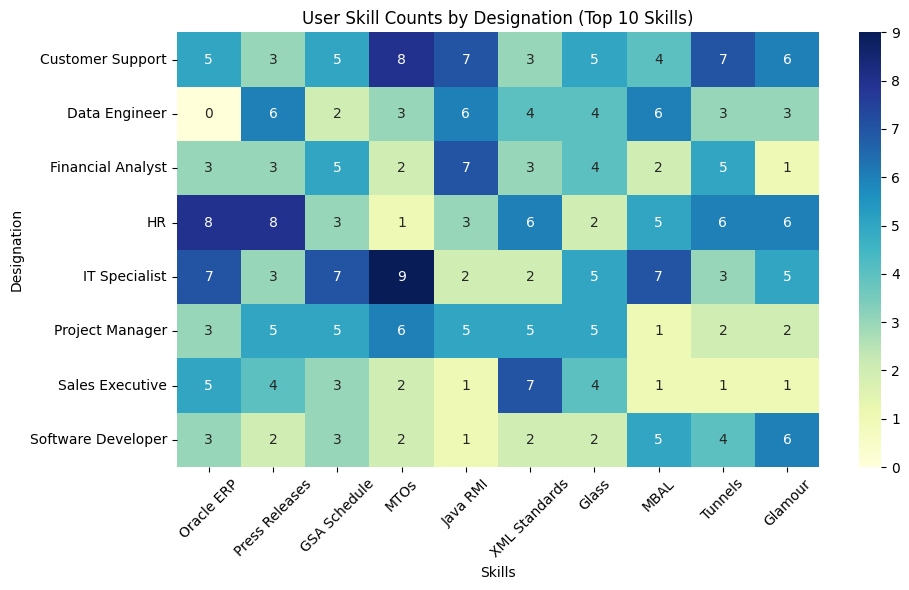

In [115]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# merged_df = transformed_dfs["User"].merge(transformed_dfs["UserSkill"], left_on='id', right_on='userId') \
#                   .merge(transformed_dfs["Skill"], left_on='skillId', right_on='id') \
#                   .merge(transformed_dfs["Designation"], left_on='designationId', right_on='id', suffixes=('', '_designation'))

# pivot_table = pd.pivot_table(
#     merged_df,
#     index='name_designation',  # Use the designation name instead of ID
#     columns='name',
#     values='userId',
#     aggfunc='count',
#     fill_value=0
# )

# pivot_table.reset_index(inplace=True)

# heatmap_data = pivot_table.set_index('name_designation')

# top_skills = heatmap_data.sum().nlargest(10).index
# heatmap_data_top10 = heatmap_data[top_skills]

# plt.figure(figsize=(10, 6))
# sns.heatmap(heatmap_data_top10, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
# plt.title('User Skill Counts by Designation (Top 10 Skills)')
# plt.xlabel('Skills')
# plt.ylabel('Designation')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()


Dimension Tables
User Dim: ['id', 'username', 'createdAt']
Designation Dim: ['id', 'name']
Course Dim: ['course_id', 'title', 'difficulty', 'language', 'totalTime', 'totalModules', 'created_at']
Skill Dim: ['id', 'name']
Fact Tables
EmployeeProgress Fact: ['userId', 'courseId', 'designationId', 'progressStatus', 'last_updated', 'modulesCompleted', 'has_certificate', 'previous_update']
CourseEnroll Fact:
['courseId', 'count_of_enrolled', 'count_of_completed_and_has_certificate'] (where count_of_completed_and_has_certificate counts the records with status "complete" and has_certificate is true)
Skill Fact: ['userId', 'skillId', 'level', 'designationId', 'courseId']

In [ ]:
# pip install scikit-learn

In [121]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# import numpy as np

# # 1. Create Dummy DataFrames

# # Users
# users = pd.DataFrame({
#     'id': [1, 2, 3, 4],
#     'username': ['Alice', 'Bob', 'Charlie', 'David'],
#     'designationId': [1, 2, 1, 2],
#     'createdAt': pd.to_datetime(['2023-01-01', '2023-01-15', '2023-02-01', '2023-02-10'])
# })

# # Courses
# courses = pd.DataFrame({
#     'course_id': [101, 102, 103, 104, 105],
#     'title': ['Course A', 'Course B', 'Course C', 'Course D', 'Course E'],
#     'difficulty': ['Easy', 'Medium', 'Hard', 'Medium', 'Easy'],
#     'language': ['English', 'English', 'Spanish', 'English', 'Spanish'],
#     'totalTime': [10, 20, 30, 25, 15],
#     'totalModules': [5, 10, 15, 8, 4],
#     'created_at': pd.to_datetime(['2023-01-10', '2023-02-20', '2023-03-01', '2023-03-05', '2023-03-10'])
# })

# # Updated Employee Progress with more balanced entries
# employee_progress = pd.DataFrame({
#     'userId': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4],
#     'courseId': [101, 102, 105, 101, 104, 103, 101, 104, 105, 102, 103, 101],
#     'progressStatus': ['Completed', 'Completed', 'Not Started', 'Completed', 'Not Started', 
#                        'Completed', 'Not Started', 'Not Started', 'Completed', 'Completed', 
#                        'In-progress', 'Not Started'],
#     'last_updated': pd.to_datetime(['2023-02-01', '2023-02-10', '2023-03-01', '2023-02-15', 
#                                      '2023-03-01', '2023-03-01', '2023-03-01', '2023-03-02',
#                                      '2023-03-03', '2023-03-04', '2023-03-05', '2023-03-06']),
#     'modulesCompleted': [5, 5, 0, 5, 0, 5, 0, 0, 5, 5, 3, 0],
#     'has_certificate': [True, True, False, True, False, True, False, False, True, True, False, False]
# })


# # Skills
# skills = pd.DataFrame({
#     'id': [1, 2, 3],
#     'name': ['Python', 'Project Management', 'Data Analysis']
# })

# # User Skills
# user_skills = pd.DataFrame({
#     'userId': [1, 1, 2, 3, 4],
#     'skillId': [1, 2, 1, 3, 1],
#     'level': ['Expert', 'Intermediate', 'Beginner', 'Intermediate', 'Expert']
# })

# # Course Skills
# course_skills = pd.DataFrame({
#     'courseId': [101, 102, 103, 104, 105],
#     'skillId': [1, 2, 1, 3, 1],
#     'level': ['Intermediate', 'Beginner', 'Intermediate', 'Expert', 'Expert']
# })

# # 2. Data Preparation
# merged_data = employee_progress.merge(users, left_on='userId', right_on='id', suffixes=('', '_user'))
# merged_data = merged_data.merge(courses, left_on='courseId', right_on='course_id', suffixes=('', '_course'))

# # 3. Feature Engineering
# user_features = merged_data.groupby('userId').agg({
#     'modulesCompleted': 'mean',
#     'has_certificate': 'mean'
# }).reset_index()

# user_features.columns = ['userId', 'avgModulesCompleted', 'completionRate']

# def calculate_skill_match(user_id):
#     user_skill_ids = user_skills[user_skills['userId'] == user_id]['skillId'].unique()
#     return len(set(user_skill_ids) & set(course_skills['skillId'].unique()))

# user_features['skillMatch'] = user_features['userId'].apply(calculate_skill_match)

# # 4. Prepare Training Data
# recommendations = []

# for user_id in merged_data['userId'].unique():
#     user_data = merged_data[merged_data['userId'] == user_id]
#     completed_courses = user_data['courseId'].unique()
    
#     all_courses = courses['course_id'].unique()
    
#     # Adding a recommendation for a course the user has already completed
#     for course in completed_courses:
#         recommendations.append({'userId': user_id, 'courseId': course, 'will_complete': 1})
    
#     # Adding recommendations for courses not completed yet
#     courses_to_recommend = [course for course in all_courses if course not in completed_courses]
#     for course in courses_to_recommend:
#         recommendations.append({'userId': user_id, 'courseId': course, 'will_complete': 0})

# recommendations_df = pd.DataFrame(recommendations)

# # 5. Combine user features with recommendations
# recommendations_df = recommendations_df.merge(user_features, on='userId', how='left')

# # 6. Check for class balance
# if recommendations_df['will_complete'].nunique() < 2:
#     raise ValueError("The target variable must contain at least two classes (0 and 1).")

# # Split the data for training
# X = recommendations_df[['avgModulesCompleted', 'completionRate', 'skillMatch']]
# y = recommendations_df['will_complete']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 7. Train the Model
# model = LogisticRegression()
# model.fit(X_train, y_train)

# # 8. Make Predictions
# recommendations_df['predicted_completion'] = model.predict(X)

# # 9. Filter Top Recommendations
# top_recommendations = recommendations_df[recommendations_df['predicted_completion'] == 1]

# print("Top Course Recommendations:")
# print(top_recommendations[['userId', 'courseId']])


Top Course Recommendations:
    userId  courseId
5        2       101
6        2       104
7        2       102
8        2       103
9        2       105
10       3       103
11       3       101
12       3       104
13       3       102
14       3       105


In [122]:
# After making predictions
recommendations_df['predicted_completion'] = model.predict(X)

# Debugging: Print the predictions
print("Predictions:")
print(recommendations_df[['userId', 'courseId', 'will_complete', 'predicted_completion']])

# 9. Filter Top Recommendations
top_recommendations = recommendations_df[recommendations_df['predicted_completion'] == 1]

print("Top Course Recommendations:")
print(top_recommendations[['userId', 'courseId']])

# Additional Debugging: Check the counts of predicted completions
print("Counts of predicted completions:")
print(recommendations_df['predicted_completion'].value_counts())


Predictions:
    userId  courseId  will_complete  predicted_completion
0        1       101              1                     0
1        1       102              1                     0
2        1       105              1                     0
3        1       103              0                     0
4        1       104              0                     0
5        2       101              1                     1
6        2       104              1                     1
7        2       102              0                     1
8        2       103              0                     1
9        2       105              0                     1
10       3       103              1                     1
11       3       101              1                     1
12       3       104              1                     1
13       3       102              0                     1
14       3       105              0                     1
15       4       105              1                     0
1